In [24]:
import numpy as np

# Potential energy function for a harmonic oscillator
def potential_energy(n, E0):
    return (0.5 + n) * E0

# Boltzmann distribution
def boltzmann_distribution(n, beta, E0):
    return np.exp(-beta * potential_energy(n, E0))

# Metropolis-Hastings algorithm for MCMC sampling
def metropolis_hastings(x0, n_samples, beta, E0):
    samples = [x0]
    x_current = x0
    n = 0
    while n < n_samples :
        # Propose a new sample from a Gaussian distribution centered at the current sample
        x_proposed = np.random.randint(0, 1e3)
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, boltzmann_distribution(x_proposed, beta, E0) / boltzmann_distribution(x_current, beta, E0))
        
        # Accept or reject the proposed sample based on the acceptance probability
        if np.random.rand() < acceptance_prob:
            x_current = x_proposed
        
        samples.append(x_current)
        n += 1
    
    return samples

# Parameters
beta = 1.0  # Inverse temperature
E0 = 2.0   # Equilibrium position
x_initial = 2  # Initial position
n_samples = 1e5  # Number of samples to generate
step_size = 0.1    # Step size for proposing new samples

# Generate samples using Metropolis-Hastings algorithm
samples = metropolis_hastings(x_initial, n_samples, beta, E0)

# Calculate the expectation value of x
expectation_value = np.mean(samples)

print("Expectation value of the harmonic oscillator:", expectation_value)


Expectation value of the harmonic oscillator: 0.18807811921880782


In [ ]:
# Return stability of a given orbit

def HillDet (s, n) :
    

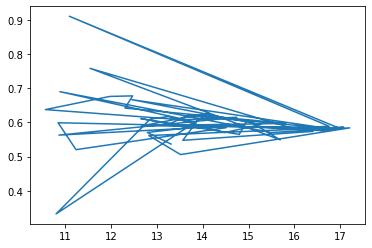

In [64]:
import matplotlib.pyplot as plt
random_numbers = np.random.uniform(4.5, 7.5, size = 50)
res = []

x = [int(10.0 ** r) for r in random_numbers]

for n in x :
    samples = metropolis_hastings(np.random.randint(0, 100), n, 1.0, 1.0)
    expectation_value = np.mean(samples)

    res.append(expectation_value)

plt.plot(np.log(x), res)


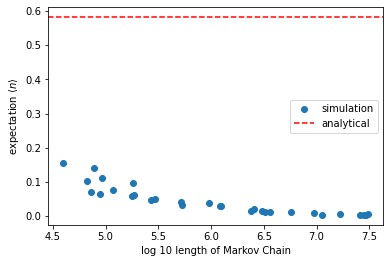

In [72]:
plt.scatter(np.log10(x), res, label = 'simulation')
plt.axhline(y=1/ (np.e - 1), color='r', linestyle='--', label = 'analytical')
plt.xlabel("log 10 length of Markov Chain")
plt.ylabel(r"expectation $\langle n \rangle$")
plt.legend()
plt.savefig('Fig1_for_MCMC.png')

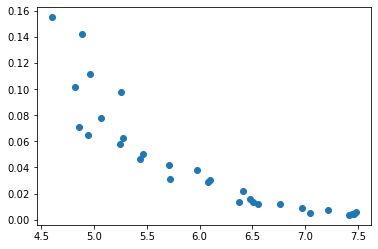

In [69]:
random_numbers = np.random.uniform(4.5, 7.5, size = 30)
res = []

x = [int(10.0 ** r) for r in random_numbers]

for n in x :
    tmp = []

    for _ in range (10) :
        samples = metropolis_hastings(np.random.randint(0, 100), n, 1.0, 1.0)
        expectation_value = np.mean(samples)
        tmp.append(expectation_value)

    res.append(np.std(np.array(tmp)))

plt.scatter(np.log10(x), res)


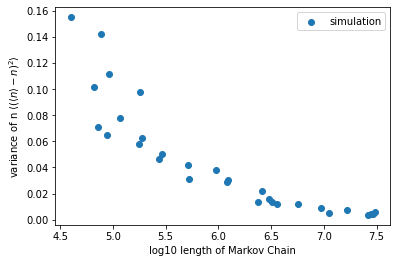

In [74]:
plt.scatter(np.log10(x), res, label = 'simulation')
plt.xlabel("log10 length of Markov Chain")
plt.ylabel(r"variance of n $\langle (\langle n \rangle- n)^2 \rangle$")
plt.legend()
plt.savefig('Fig2_for_MCMC.png')

In [45]:
res = []

samples = metropolis_hastings(np.random.randint(0, 100), 1e7, 1.0, 1.0)
expectation_value = np.mean(samples)

res.append(expectation_value)

#res.sort()

#x = np.linspace(min(res), max(res), 100)
#fig = [0]

# for i in range (len(x) - 1) :
#     for j in range (len(res)) :
#         if res[j] > x[i] :
#             tmp = j - fig[-1]
#             fig.append (tmp)
#             break

print ('Mean:', statistics.mean(samples))
print ('Standard deviation:', statistics.stdev(samples))

Mean: 0.5893910410608959
Standard deviation: 0.9645858520520469


In [26]:
import numpy as np
from numpy.linalg import eig
import os
import cyclehunter
from cyclehunter import *
from scipy.optimize import minimize
from scipy.linalg import eig
import matplotlib.pyplot as plt
import time

def weight_zeta(n, p, musq) :
    x = p[n] 
    T = len(x)
    Lam = stab(x, musq)
    w = np.absolute(T / (Lam - 1))

    return w

def stab(cycle, musq) :
    ret = 1
    # find the Jacobian matrix for a given cycle and musqr
    Jac = np.array ([[1, 0], [0, 1]])
    for x in cycle :
        tmp = np.array ([[- 3 * musq * (x ** 2) + musq + 2, -1], [1, 0]])
        Jac = np.matmul (tmp, Jac)
        w, v = eig (Jac)
        #find expanding eigenvalue
        for l in np.absolute(w) :
            if l > 1 :
                ret *= l

    return (ret)

# Metropolis-Hastings algorithm for MCMC sampling
def metropolis_hastings_zeta(x0, n_samples, p, musq):
    samples = [p[x0]]
    x_current = x0
    n = 0
    while n < n_samples :
        # Propose a new sample from a Gaussian distribution centered at the current sample
        x_proposed = np.random.randint(0, len(p))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, weight_zeta(x_proposed, p, musq) / weight_zeta(x_current, p, musq))
        
        # Accept or reject the proposed sample based on the acceptance probability
        if np.random.rand() < acceptance_prob:
            x_current = x_proposed
        
        samples.append(p[x_current])
        n += 1
    
    return samples

# QR decomposition 
def qr_decomposition(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = A[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], A[:, j])
            v -= R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    
    det = 1
    
    for i in range(n):
        det *= R[i, i]
    
    #det *= np.linalg.det(Q)
        
    return Q, R, det

# Calculate Hill determinant
def Hill_det (sample, musq) :
    J = []
    for cycle in sample:
        A = [[] for j in range (len(cycle))]

        for j in range (len(cycle)):
            for k in range (len(cycle)):
                if (j == k):
                    A[j].append (musq + 2 - 3 * musq * cycle[j]**2 )
                elif (k == j+1 or k == j-1 or k == j+len(cycle)-1 or k == j-len(cycle)+1):
                    A[j].append (-1)
                else: 
                    A[j].append (0)

        B = np.array(A)
        Q, R, det = qr_decomposition(B)
        c = det
        J.append(c)

    return (np.array(J))

In [35]:
# MCMC simulation with distribution given by partition function
def metropolis_hastings_part(x0, n_samples, A, musq):
    samples = [A[x0]]
    x_current = x0
    n = 0
    while n < n_samples :
        # Propose a new sample from a Gaussian distribution centered at the current sample
        x_proposed = np.random.randint(0, len(A))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, weight_part(x_proposed, A, musq) / weight_part(x_current, A, musq))
        
        # Accept or reject the proposed sample based on the acceptance probability
        if np.random.rand() < acceptance_prob:
            x_current = x_proposed
        
        samples.append(A[x_current])
        n += 1
    
    return samples

# Weight calculation for partition function (periodic states instead of orbits)
def weight_part (n, A, musq) :
    x = A[n]
    J = Hill_det([x], musq)

    return (1/J)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


ValueError: x and y must be the same size

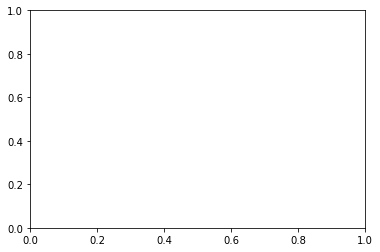

In [36]:
random_numbers = np.random.uniform(4.5, 7, size = 60)
res = []

musq = 3.5
n = [int(10.0 ** r) for r in random_numbers]
x_initial = np.random.randint(0, len(p.keys()))
it = 0
res_zeta = []
res_part = []

for n_samples in n :
    tmp = []

    if it % 2 == 0 :
        samples_zeta = metropolis_hastings_zeta(x_initial, n_samples, p, musq)
        # Calculate average stability <A> (integrated)
        stability = -1 * np.log(Hill_det (samples_zeta, musq))
        # Expectation of period
        T = np.array([len(x) for x in samples_zeta])
        # Calculate the expectation value of x
        expectation_value = np.mean(stability / T)
        # For calculation of sample variance
        res_zeta.append(expectation_value)

    else :
        samples_part = metropolis_hastings_part(x_initial, n_samples, A, musq)
        # Calculate average stability <A> (integrated)
        stability = -1 * np.log(Hill_det (samples_part, musq))
        # Expectation of period
        T = np.array([len(x) for x in samples_part])
        # Calculate the expectation value of x
        expectation_value = np.mean(stability / T)
        # For calculation of sample variance
        res_part.append(expectation_value)
        
    it += 1
    print (it)


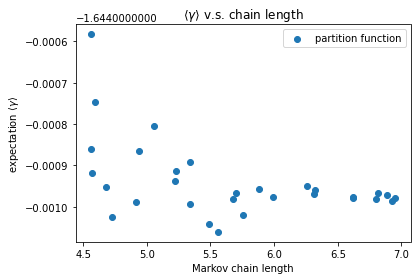

In [44]:
n_zeta = []
n_part = []

for i in range (60) :
    if i % 2 == 0 :
        n_zeta.append(n[i])
    else :
        n_part.append(n[i])
        
#plt.scatter(np.log10(n_zeta), res_zeta, label = 'zeta function')
plt.scatter(np.log10(n_part), res_part, label = 'partition function')
plt.xlabel('Markov chain length')
plt.ylabel (r"expectation $\langle \gamma \rangle$")
plt.title (r"$\langle \gamma \rangle$ v.s. chain length")
plt.legend()
plt.savefig('exp.pdf')

In [2]:
# Example lists of keys and values
# Set initial conditions and pool for prime orbits
n = 15
musq = 3.5

# Generate a pool for all prime orbits up to length n
values = []
for i in range(n) :
    print (i)
    x = PhiK(i+1, 4, musq)
    x = x.generate_states()
    x = x.prime_cycles()
    y = x.hunt()
  
    values = values + y.states.tolist()

keys = [i for i in range (len(values))]

# Open a file for writing
with open('zeta_dic.txt', 'w') as file:
    # Iterate over the keys and values simultaneously using zip
    for key, value in zip(keys, values):
        # Write each key-value pair to the file with a colon separator
        file.write(f"{key}:{value}\n")

0
1
2
3
4
5
6
7
8
9
10
11


In [4]:
import numpy as np
from numpy.linalg import eig
import os
import cyclehunter
from cyclehunter import *
from scipy.optimize import minimize
from scipy.linalg import eig
import matplotlib.pyplot as plt
import time

values = []

x = PhiK(14, 4, 3.5)
x = x.generate_states()
x = x.prime_cycles()
y = x.hunt()

values = y.states.tolist()

keys = [i for i in range (len(values))]

# Open a file for writing
with open('part_dic_14.txt', 'w') as file:
    # Iterate over the keys and values simultaneously using zip
    for key, value in zip(keys, values):
        # Write each key-value pair to the file with a colon separator
        file.write(f"{key}:{value}\n")

In [33]:
import ast
# Open the text file for reading
with open('zeta_dic.txt', 'r') as file:
    # Initialize an empty dictionary
    p = {}
    
    # Iterate through each line in the file
    for line in file:
        # Split each line into key and value based on the delimiter (in this case, ':')
        key, value = line.strip().split(':')
        
        # Assign key-value pair to the dictionary
        p[int(key)] = [int(item) for item in ast.literal_eval(value)]
print (len(p.keys()))

122640


In [46]:
import ast
n = len(p.keys())
# Open the text file for reading
with open('part_dic_13.txt', 'r') as file:
    # Initialize an empty dictionary
    
    # Iterate through each line in the file
    for line in file:
        # Split each line into key and value based on the delimiter (in this case, ':')
        key, value = line.strip().split(':')
        
        # Assign key-value pair to the dictionary
        p[int(key) + n] = [int(item) for item in ast.literal_eval(value)]

n = len(p.keys())
# Open the text file for reading
with open('part_dic_14.txt', 'r') as file:
    # Initialize an empty dictionary
    
    # Iterate through each line in the file
    for line in file:
        # Split each line into key and value based on the delimiter (in this case, ':')
        key, value = line.strip().split(':')
        
        # Assign key-value pair to the dictionary
        p[int(key) + n] = [int(item) for item in ast.literal_eval(value)]

print (len(p.keys()))

656470


In [59]:
def take_first_n_terms(dictionary, n):
    # Initialize an empty dictionary to store the result
    new_dict = {}
    
    # Iterate over the original dictionary and add the first n key-value pairs
    for i, (key, value) in enumerate(dictionary.items()):
        if i < n:
            new_dict[key] = value
        else:
            break
    
    return new_dict

numbers = np.linspace(4*np.log(10), np.log(len(p.keys())), 15)
res = []

musq = 3.5
n = [int(np.exp(r)) for r in numbers]

it = 0
res_zeta = []

for n_samples in n :
    tmp = take_first_n_terms(p, n_samples)
    x_initial = np.random.randint(0, len(tmp.keys()))
    samples_zeta = metropolis_hastings_zeta(x_initial, 1e5, tmp, musq)
    # Calculate average stability <A> (integrated)
    stability = -1 * np.log(Hill_det (samples_zeta, musq))
    # Expectation of period
    T = np.array([len(x) for x in samples_zeta])
    # Calculate the expectation value of x
    expectation_value = np.mean(stability / T)
    # For calculation of sample variance
    res_zeta.append(expectation_value)
        
    it += 1
    print (it)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


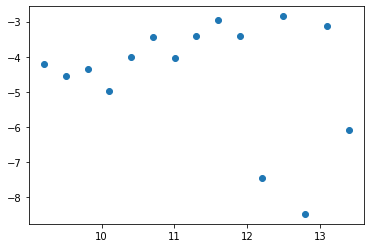

In [60]:
plt.scatter(numbers, np.log(np.absolute(np.array(res_zeta)+1.6439)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


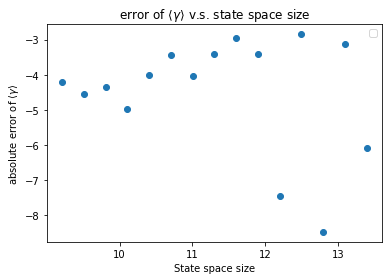

In [61]:
plt.scatter(numbers, np.log(np.absolute(np.array(res_zeta)+1.6439)))
plt.xlabel('State space size')
plt.ylabel (r"absolute error of $\langle \gamma \rangle$")
plt.title (r"error of $\langle \gamma \rangle$ v.s. state space size")
plt.legend()
plt.savefig('error.pdf')


80